In [1]:
DATASET_DIR = '../input/severstal-steel-defect-detection/'
TEST_SIZE = 0.1
RANDOM_STATE = 123

NUM_TRAIN_SAMPLES = 20 # The number of train samples used for visualization
NUM_VAL_SAMPLES = 20 # The number of val samples used for visualization
COLORS = ['b', 'g', 'r', 'm'] # Color of each class

# Import modules

In [2]:
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

from shutil import copyfile
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv(os.path.join(DATASET_DIR, 'train.csv'))

In [4]:
df['Image'] = df['ImageId_ClassId'].map(lambda x: x.split('_')[0])
df['HavingDefection'] = df['EncodedPixels'].map(lambda x: 0 if x is np.nan else 1)

image_col = np.array(df['Image'])
image_files = image_col[::4]
y = np.array(df['HavingDefection']).reshape(-1, 4)

In [5]:
num_img_class_1 = np.sum(y[:, 0])
num_img_class_2 = np.sum(y[:, 1])
num_img_class_3 = np.sum(y[:, 2])
num_img_class_4 = np.sum(y[:, 3])
print('Class 1: {} images'.format(num_img_class_1))
print('Class 2: {} images'.format(num_img_class_2))
print('Class 3: {} images'.format(num_img_class_3))
print('Class 4: {} images'.format(num_img_class_4))

Class 1: 897 images
Class 2: 247 images
Class 3: 5150 images
Class 4: 801 images


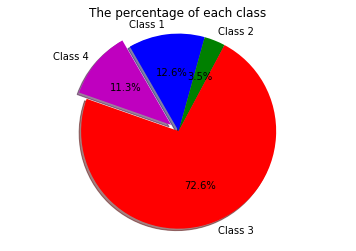

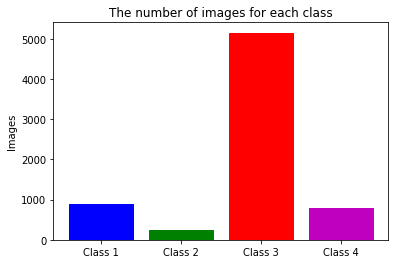

In [6]:
labels = 'Class 1', 'Class 2', 'Class 3', 'Class 4'
sizes = np.sum(y, axis=0)
explode = (0, 0, 0, 0.1)

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', colors=COLORS, shadow=True, startangle=120, counterclock=False)
ax.axis('equal')
ax.set_title('The percentage of each class')

plt.show()

# =========================

y_pos = np.arange(len(labels))

barlist = plt.bar(y_pos, sizes, align='center')
plt.xticks(y_pos, labels)
plt.ylabel('Images')
plt.title('The number of images for each class')
for i in range(4):
    barlist[i].set_color(COLORS[i])

plt.show()

# Split dataset into training and validation sets

In [7]:
X_train, X_val, y_train, y_val = train_test_split(image_files, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [8]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(11311,)
(11311, 4)
(1257,)
(1257, 4)


# Visualize some images and corresponding labels

In [9]:
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [10]:
def show_samples(samples):
    for i in range(len(samples)):
        fig, axes = plt.subplots(1, 1, figsize=(15, 10))
        sample = samples[i]
        img_path = os.path.join(DATASET_DIR, 'train_images', sample[0])
        img = cv2.imread(img_path)

        # Get annotations
        labels = df[df['ImageId_ClassId'].str.contains(sample[0])]['EncodedPixels']

        patches = []
        for idx, rle in enumerate(labels.values):
            if rle is not np.nan:
                mask = rle2mask(rle)
                contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                for contour in contours:
                    poly_patch = Polygon(contour.reshape(-1, 2), closed=True, linewidth=1, edgecolor=COLORS[idx], fill=False)
                    patches.append(poly_patch)
        p = PatchCollection(patches, match_original=True, cmap=matplotlib.cm.jet)

        axes.imshow(img/255)
        axes.set_title('{} - ({})'.format(sample[0], ', '.join(sample[1].astype(np.str))))
        axes.add_collection(p)
        plt.show()

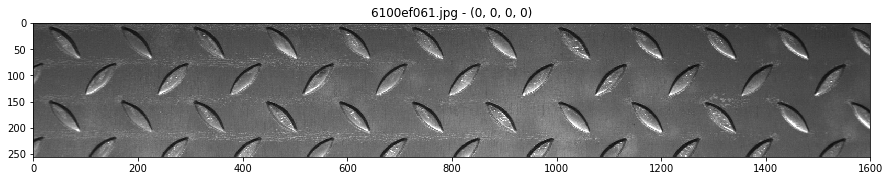

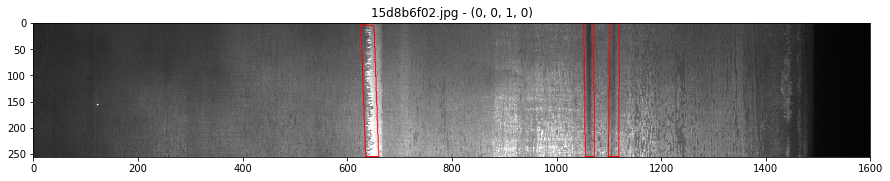

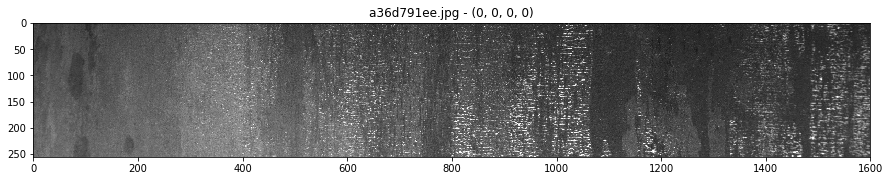

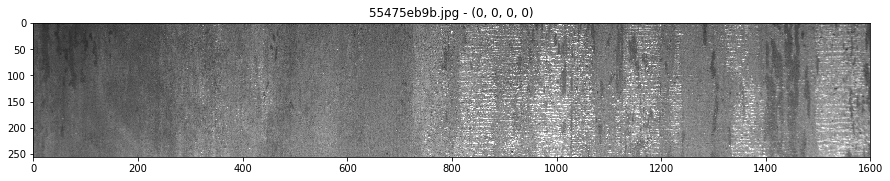

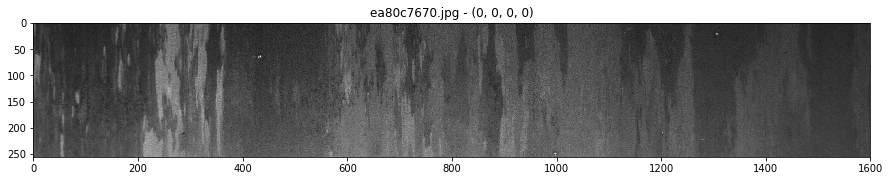

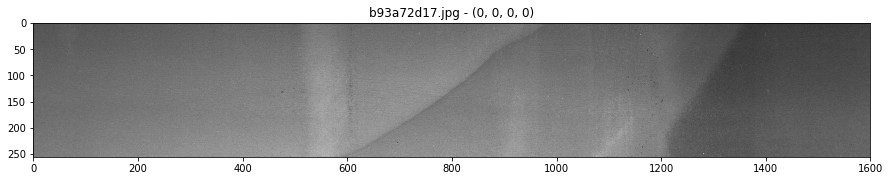

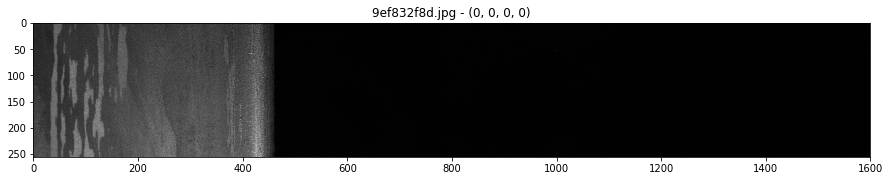

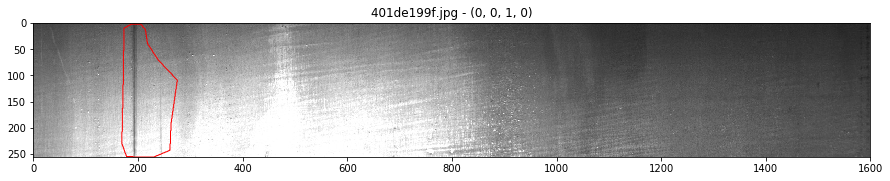

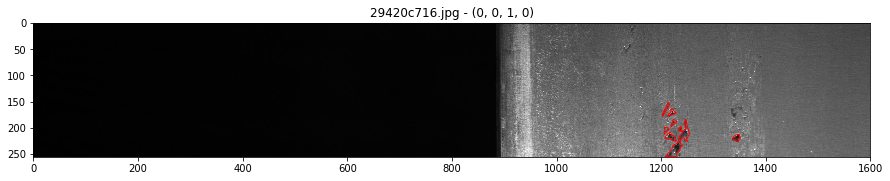

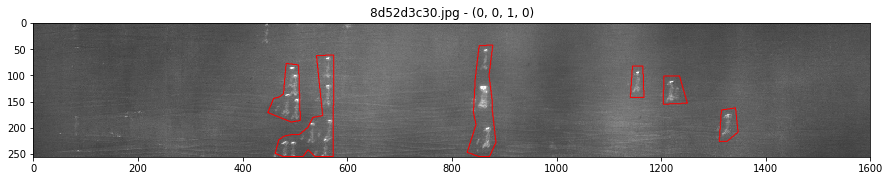

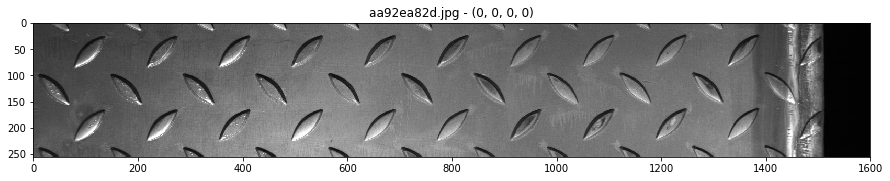

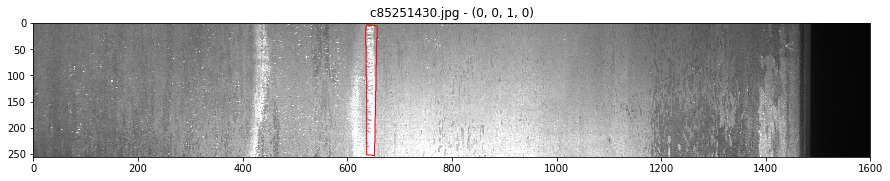

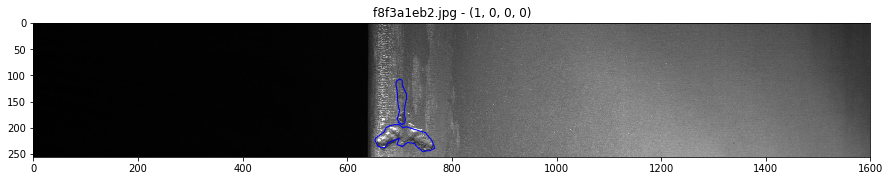

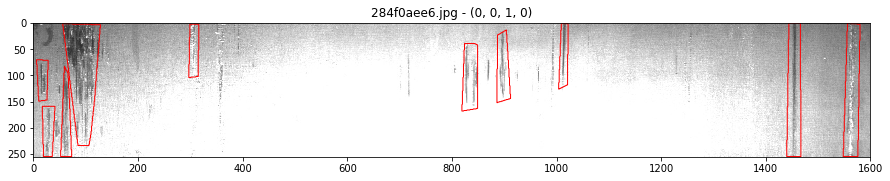

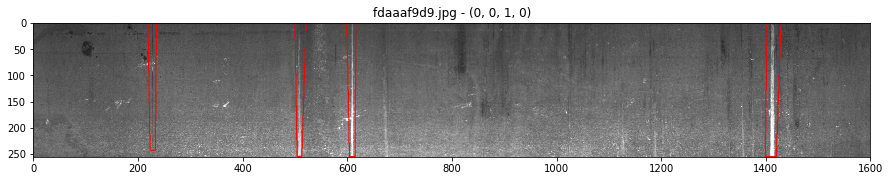

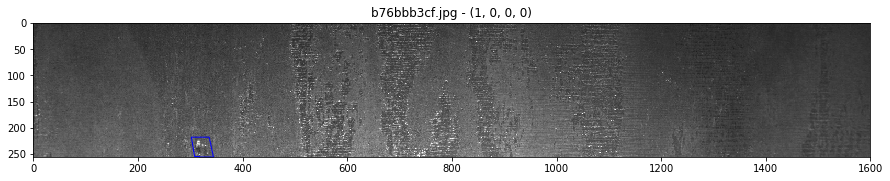

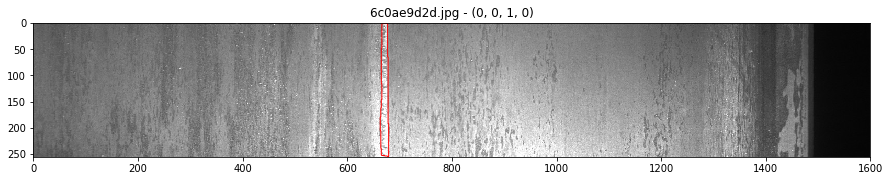

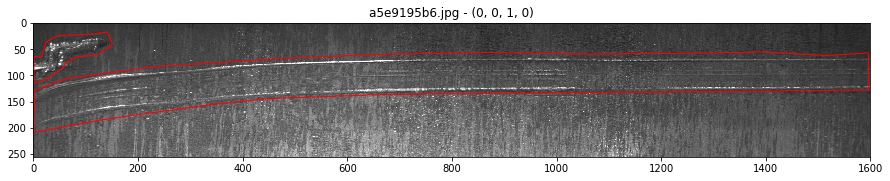

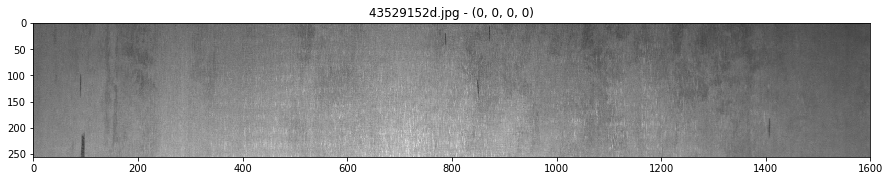

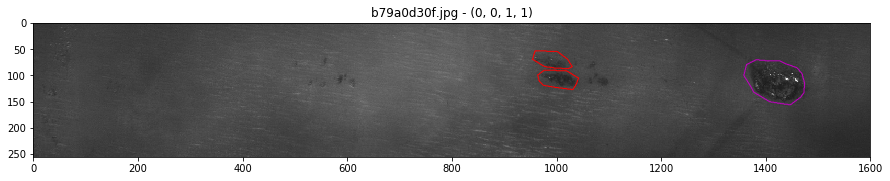

In [11]:
train_pairs = np.array(list(zip(X_train, y_train)))
train_samples = train_pairs[np.random.choice(train_pairs.shape[0], NUM_TRAIN_SAMPLES, replace=False), :]

show_samples(train_samples)

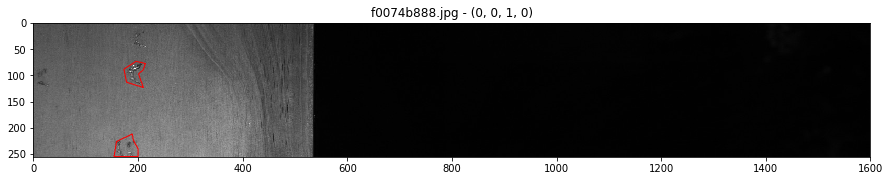

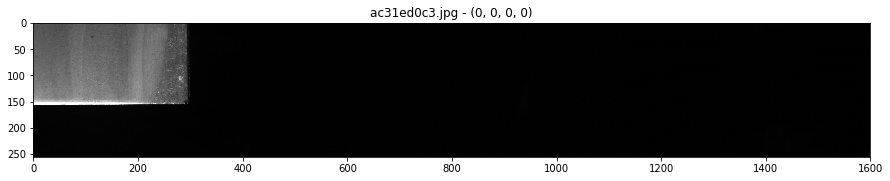

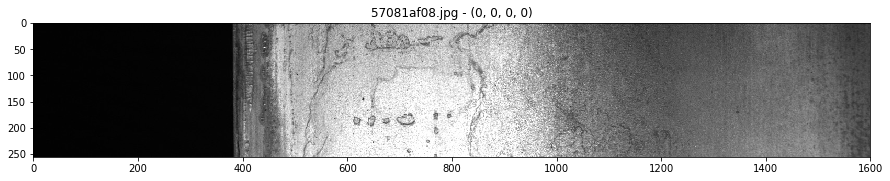

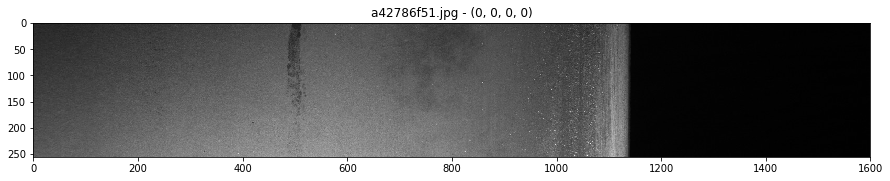

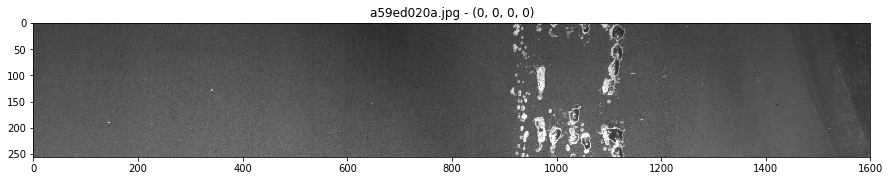

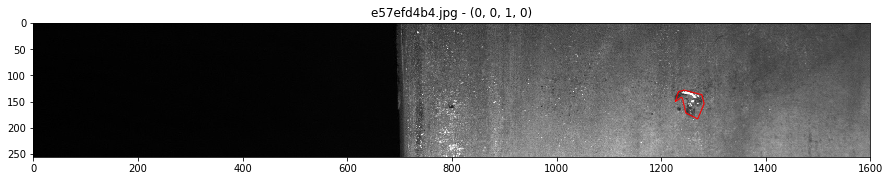

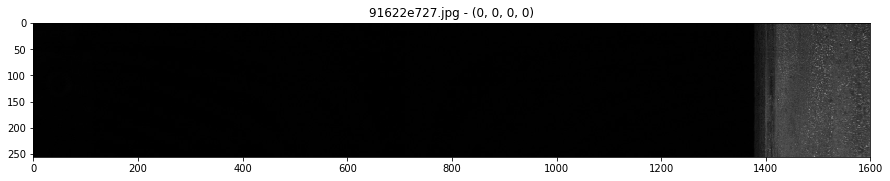

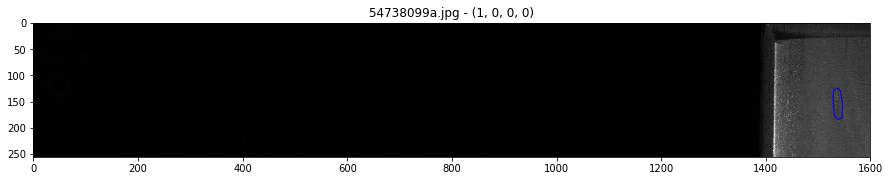

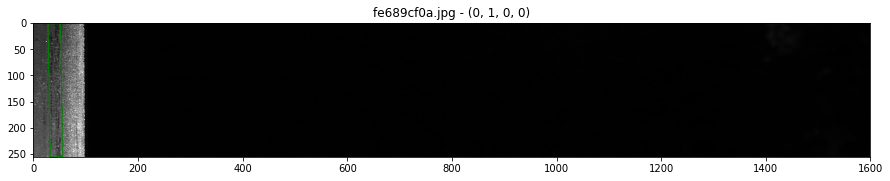

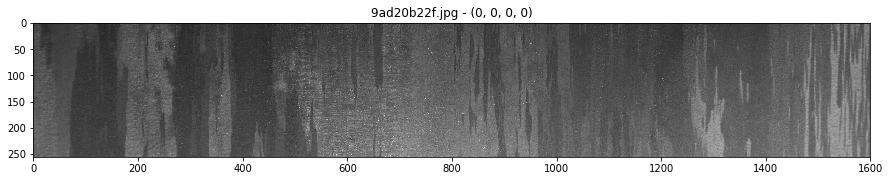

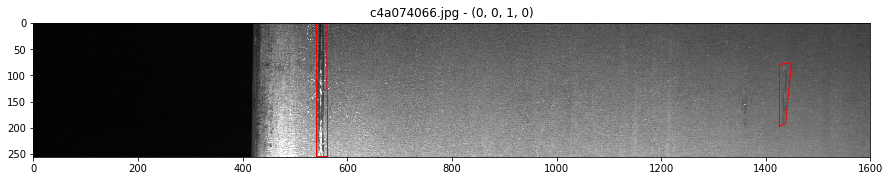

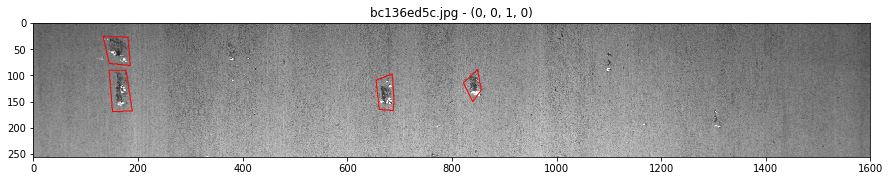

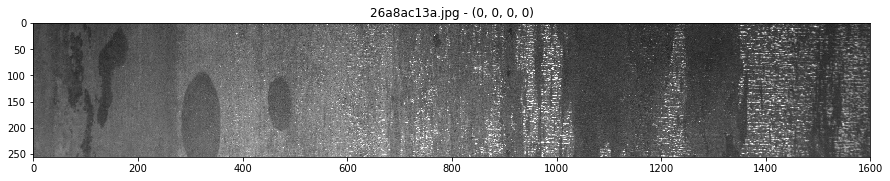

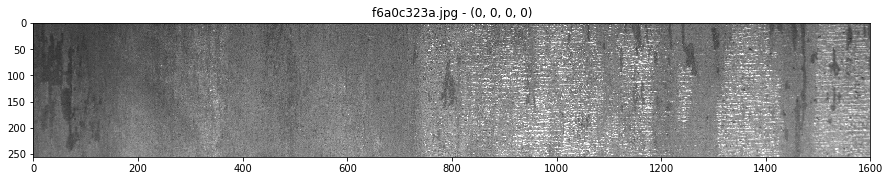

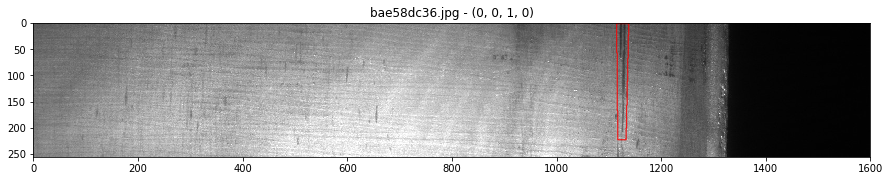

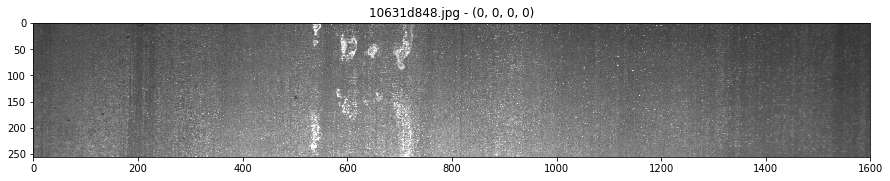

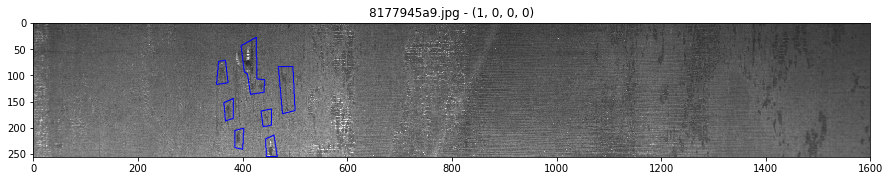

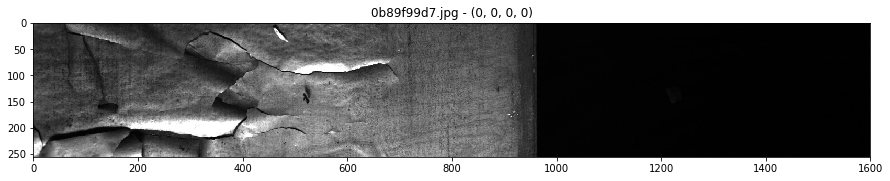

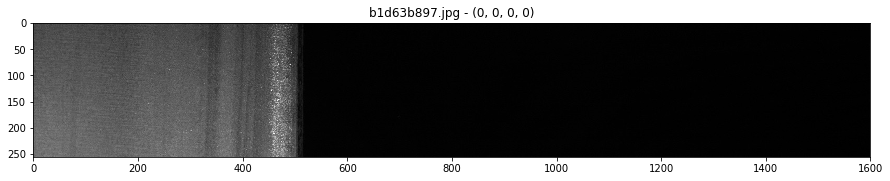

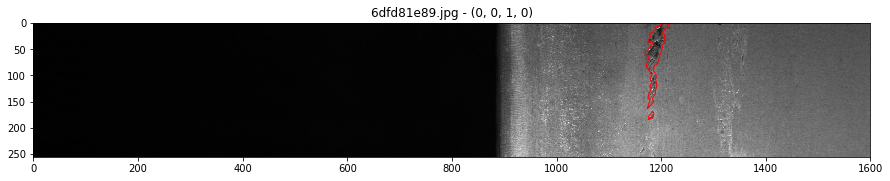

In [12]:
val_pairs = np.array(list(zip(X_val, y_val)))
val_samples = val_pairs[np.random.choice(val_pairs.shape[0], NUM_VAL_SAMPLES, replace=False), :]

show_samples(val_samples)

# Copy images into right folders

In [13]:
!mkdir train_images
!mkdir val_images

In [14]:
for image_file in X_train:
    src = os.path.join(DATASET_DIR, 'train_images', image_file)
    dst = os.path.join('./train_images', image_file)
    copyfile(src, dst)

for image_file in X_val:
    src = os.path.join(DATASET_DIR, 'train_images', image_file)
    dst = os.path.join('./val_images', image_file)
    copyfile(src, dst)

# Zip training and validation sets

In [15]:
!apt install zip




The following NEW packages will be installed:
  zip
0 upgraded, 1 newly installed, 0 to remove and 18 not upgraded.
Need to get 234 kB of archives.
After this operation, 623 kB of additional disk space will be used.
Get:1 http://deb.debian.org/debian stretch/main amd64 zip amd64 3.0-11+b1 [234 kB]
Fetched 234 kB in 0s (2298 kB/s)
debconf: delaying package configuration, since apt-utils is not installed

78Selecting previously unselected package zip.
(Reading database ... 58908 files and directories currently installed.)
Preparing to unpack .../zip_3.0-11+b1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 16%] [#########.................................................] 8Unpacking zip (3.0-11+b1) ...
7Progress: [ 33%] [###################.......................................] 87Progress: [ 50%] [#############################.............................] 8Setting up zip (3.0-11+b1) ...
7Progress: [ 66%] [########

In [16]:
!zip -r -m -1 -q train_images.zip ./train_images
!zip -r -m -1 -q val_images.zip ./val_images

In [17]:
# y_train = list(map(lambda x: ' '.join(x.astype(np.str)), y_train))
# y_val = list(map(lambda x: ' '.join(x.astype(np.str)), y_val))
y_train = [' '.join(y.astype(np.str)) for y in y_train]
y_val = [' '.join(y.astype(np.str)) for y in y_val]

In [18]:
print(len(y_train))
print(len(y_val))

11311
1257


# Save labels

In [19]:
train_set = {
    'ImageId': X_train,
    'Label': y_train
}

val_set = {
    'ImageId': X_val,
    'Label': y_val
}

train_df = pd.DataFrame(train_set)
val_df = pd.DataFrame(val_set)

train_df.to_csv('./train.csv', index=False)
val_df.to_csv('./val.csv', index=False)